<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Thu Aug  1 14:53:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             20W /  320W |    1094MiB /  10240MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.4.0


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=ToTensor())

test_data = datasets.MNIST(root='data',
                            train=False,
                            download=True,
                            transform=ToTensor()) 

len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
class_names = train_data.classes
image.shape, class_names

(torch.Size([1, 28, 28]),
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

## 6. Visualize at least 5 different samples of the MNIST training dataset.

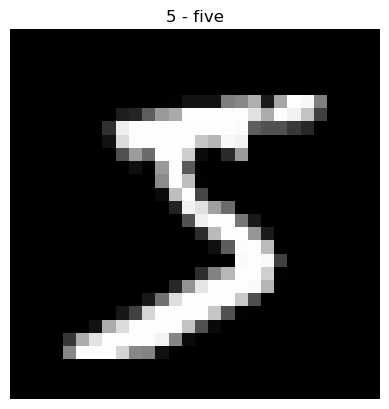

In [5]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False);

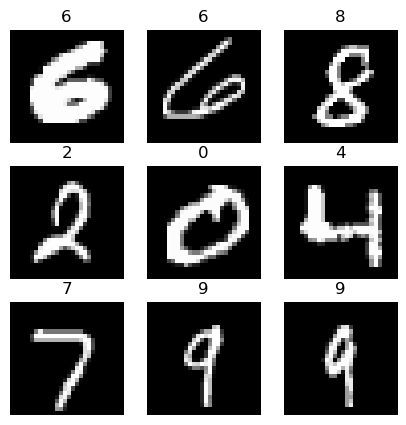

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(5,5))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [8]:
for sample in next(iter(train_dataloader)):
    print(sample.shape) # batch of images and their labels

torch.Size([32, 1, 28, 28])
torch.Size([32])


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [9]:
class MNISTModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
    
model_0 = MNISTModel0(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

In [10]:
from torchmetrics import Accuracy

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names))

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [11]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")
    
def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}\n")

In [12]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
from helper_functions import print_train_time

train_time_start = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
    train_time_end = timer()
    total_train_time = print_train_time(start=train_time_start,
                                        end=train_time_end,
                                        device=device)

c:\Users\mmdie\miniconda3\envs\pytorch_course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.37616 | Train acc: 0.86802


 20%|██        | 1/5 [00:12<00:50, 12.59s/it]

Test loss: 0.0645, Test acc: 0.9781


Train time on cpu: 12.591 seconds
Epoch: 1
------
Train loss: 0.07197 | Train acc: 0.97738


 40%|████      | 2/5 [00:25<00:37, 12.59s/it]

Test loss: 0.0588, Test acc: 0.9794


Train time on cpu: 25.176 seconds
Epoch: 2
------
Train loss: 0.05492 | Train acc: 0.98305


 60%|██████    | 3/5 [00:37<00:25, 12.63s/it]

Test loss: 0.0459, Test acc: 0.9846


Train time on cpu: 37.863 seconds
Epoch: 3
------
Train loss: 0.04672 | Train acc: 0.98560


 80%|████████  | 4/5 [00:50<00:12, 12.62s/it]

Test loss: 0.0378, Test acc: 0.9880


Train time on cpu: 50.457 seconds
Epoch: 4
------
Train loss: 0.04060 | Train acc: 0.98718


100%|██████████| 5/5 [01:03<00:00, 12.61s/it]

Test loss: 0.0419, Test acc: 0.9860


Train time on cpu: 63.075 seconds


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

In [18]:
def eval_model(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.to(device)
    model.eval()    
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc.item()}

In [19]:
model_results = eval_model(model=model_0,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)

model_results

100%|██████████| 313/313 [00:01<00:00, 252.85it/s]


{'model_name': 'MNISTModel0',
 'model_loss': 0.041906487196683884,
 'model_acc': 0.9860223531723022}

In [35]:
batch, batch_labels = next(iter(train_dataloader))

In [40]:
output = model_0(batch)
output.argmax(dim=1)

tensor([0, 2, 0, 6, 9, 8, 9, 0, 0, 3, 6, 3, 7, 2, 2, 6, 2, 1, 0, 1, 1, 3, 9, 7,
        0, 7, 3, 9, 4, 7, 2, 0])

In [39]:
torch.softmax(output, dim=0).argmax(dim=1)

tensor([0, 2, 0, 5, 9, 8, 9, 0, 4, 3, 5, 3, 7, 2, 2, 6, 2, 1, 5, 1, 1, 3, 9, 7,
        0, 7, 3, 9, 4, 7, 2, 0])

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [45]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [43]:
y_preds = []
model_0.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions'):
        y_logit = model_0(X)
        y_pred = y_logit.argmax(dim=1)
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 283.73it/s]


tensor([7, 2, 1,  ..., 4, 5, 6])

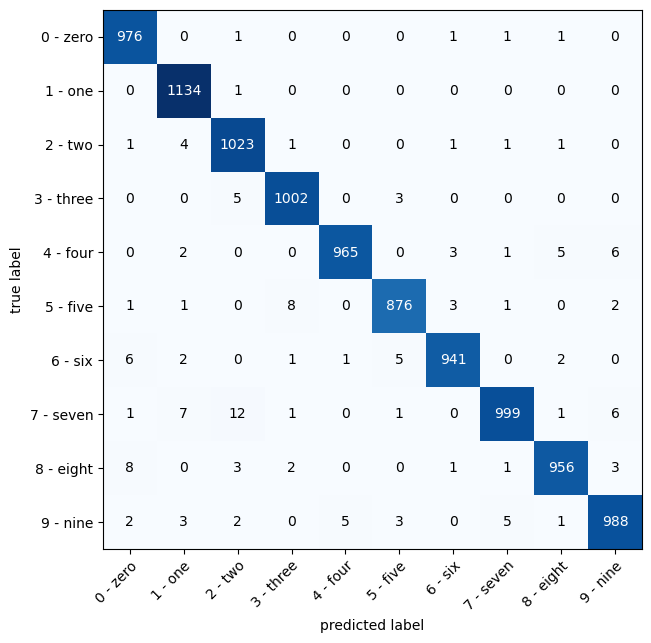

In [46]:
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,7))

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?